In [1]:
import csv
import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import os.path
import pandas as pd


def read_file(filename):
    d = []
    with open(filename) as file:
        data = csv.reader(file)
        for row in data:
            d.append(row)
    
    for item in d:
        item[-1] = item[-1].rstrip()
        
    d = d[1:]
    return d

def get_turnstiles(filename):
    data = read_file(filename)
    #print(data[1])
    newDict = defaultdict(list)
    for item in data:
        newDict[tuple(item[:4])].append(item[4:])
        
    return newDict

def print_x_dict_kv(dictionary, numKeys):
    for key in sorted(dictionary)[:numKeys]:
        print("{}: {}".format(key,dictionary[key]))
        
def get_ts_timeseries(filename):
    data = get_turnstiles(filename)
    newDict = defaultdict(list)
    for k,v in data.items():
        for item in v:
            dt = item[2] + ' ' + item[3]
            dt = datetime.datetime.strptime(dt, "%m/%d/%Y %H:%M:%S")
            entries = int(item[5])
            ts = [dt, entries]
            newDict[k].append(ts)
            
    for k,v in newDict.items():
        newDict[k] = sorted(v)
    
    for item in newDict.values():
        assert item == sorted(item)        

    return newDict  

def get_ts_timeblock_entries(filename):
    data = get_ts_timeseries(filename)
    
    newDict = {turnstile: [[v[i][0],
                            v[i+1][1]-v[i][1],
                            v[i+1][0]-v[i][0]] for i in range(len(v)-1) 
                            if 0 <= v[i+1][1]-v[i][1] <= 5000] 
                            for turnstile,v in data.items()}
    
    return newDict

def dframes_of_weeks_and_hours(*args): 
    
    '''{(c/a, unit, station):
                            {day:
                                {time: count}
                            }
        }'''
    
    full_dict = defaultdict(lambda : defaultdict(lambda : defaultdict(int)))
    cols = ["Saturday","Sunday","Monday","Tuesday","Wednesday","Thursday","Friday"]
    
    for file in args:
        data = get_ts_timeblock_entries(file)    
        
        
        for k,v in data.items():
            newKey = k[:2] + (k[3],)
            #by_day = defaultdict(lambda : defaultdict(int))
            
            for item in v:
                day_string = item[0].strftime("%A")
                time = item[0].time()
                round_time = datetime.datetime.strptime(
                            str(int(time.hour / 4) * 4).zfill(2), "%H")
                round_time = round_time.time()
                #print(type(round_time))
                #break
                full_dict[newKey][day_string][round_time] += item[1] 
    
    
    df_dict = {turnstile: pd.DataFrame.from_dict(value) 
               for turnstile, value in full_dict.items()}
    for k,v in df_dict.items():
        df_dict[k] = v[cols]
        
    return df_dict


summer_data = dframes_of_weeks_and_hours('turnstile_150530.csv',  'turnstile_150606.csv', 
                                         'turnstile_150613.csv', 'turnstile_150620.csv', 
                                         'turnstile_150627.csv', 'turnstile_150704.csv', 
                                         'turnstile_150711.csv', 'turnstile_150718.csv', 
                                         'turnstile_150725.csv', 'turnstile_150801.csv', 
                                         'turnstile_150801.csv', 'turnstile_150808.csv', 
                                         'turnstile_150815.csv', 'turnstile_150822.csv', 
                                         'turnstile_150829.csv', 'turnstile_150905.csv', 
                                         'turnstile_150912.csv')

#print_x_dict_kv(summer_data, 10)
   

## Heatmap

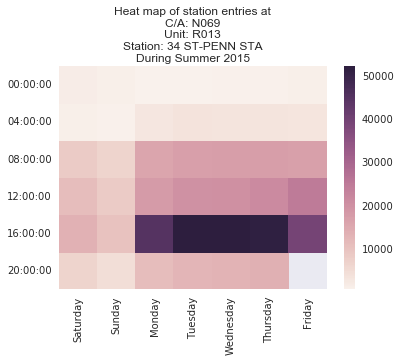

In [90]:
%matplotlib inline 
import seaborn as sns

#penn = summer_data[('N069', 'R013', '34 ST-PENN STA')]
#st_49 = summer_data[('A016', 'R081', '49 ST-7 AVE')]
#print(penn)


def get_heatmap_for_entryway(station_unit):
    place = summer_data[station_unit]
    ax = plt.axes()
    sns.heatmap(place, ax = ax)
    ax.set_title("Heat map of station entries at\n" \
                    "C/A: {}\n" \
                    "Unit: {}\n" \
                    "Station: {}\n" \
                    "During Summer 2015".format(station_unit[0],station_unit[1],station_unit[2]))
    
get_heatmap_for_entryway(('N069', 'R013', '34 ST-PENN STA'))

## Bar Plot of total entries

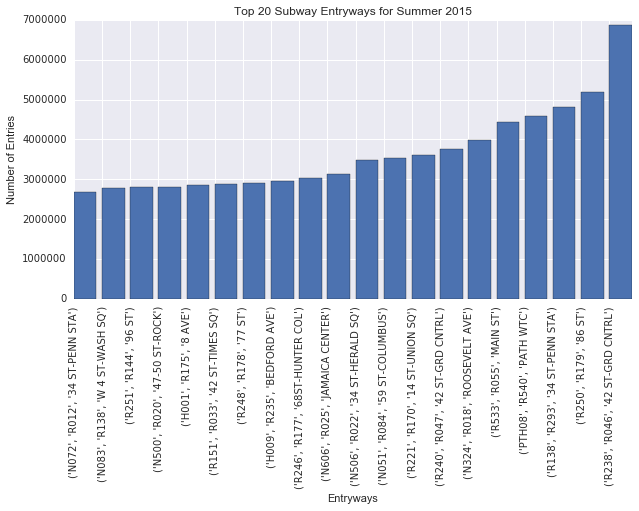

In [26]:
def plot_total_riders_by_entryway(data):
    
    num_entryways = len(data)
    x = range(1,num_entryways+1)
    entryway_names = []
    num_entries = []
    cols = ["Saturday","Sunday","Monday","Tuesday","Wednesday","Thursday","Friday"]
    
    for k,df in data.items():
        entryway_total_entries = 0
        entryway_names.append(k)
        for day in cols:  
            entryway_total_entries += df[day].sum()
        num_entries.append(int(entryway_total_entries))
        
    entryway_names, num_entries = (list(t) for t in 
                                   zip(*sorted(zip(entryway_names, num_entries), 
                                    key = lambda x: x[1]))) #sort both concurrently
    
    #print(entryway_names[-20:], num_entries[-20:])
    
    title_name = "Top 20 Subway Entryways for Summer 2015"    
        
    plt.figure(figsize=(10,5))
    plt.title(title_name)
    plt.xticks(x, entryway_names, rotation='vertical')
    plt.xlabel('Entryways')
    plt.ylabel('Number of Entries')
    plt.bar(x[-20:], num_entries[-20:])
    
    return entryway_names, num_entries

ewn1, ne1 = plot_total_riders_by_entryway(summer_data)

In [69]:
ca = [entryway[0].strip() for entryway in ewn1]
unit = [entryway[1].strip() for entryway in ewn1]
station = [entryway[2].strip() for entryway in ewn1]

In [70]:
new_dict = {"ca": ca,
                "unit": unit,
                "station": station,
                "total entries": ne1}

new_df = pd.DataFrame(needed_dict, columns=['ca', 'unit', 'station', 'total entries'])

In [77]:
def read_old_data_file(path):
    with open(path) as file:
        old_data = pd.read_csv(file)
        
    return old_data

#print(read_old_data_file('../wealth_startups_mta_entrances.csv'))

def merge_data(old_path, new_data):
    old_data = read_old_data_file(old_path)
    merge = pd.DataFrame.merge(old_data, new_data, on = ['unit', 'ca', 'station'])
    
    #print(old_data, new_data)
    #print(merge)
    
    #export to csv
    merge.to_csv("../everything_for_mta_entrances.csv", index = False)
    
    
    
merge_data('../wealth_startups_mta_entrances.csv', new_df)

## Needed Heat Maps

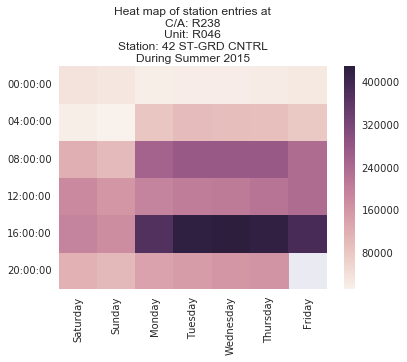

In [91]:
get_heatmap_for_entryway(('R238', 'R046', '42 ST-GRD CNTRL'))